#### HW2 - Regresja
RandomForestClassifier i XGBClassifier\
Jan Krężel

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

In [196]:
X_train = pd.read_csv("data/airline_passenger_satisfaction/train.csv", index_col=0)
X_test = pd.read_csv("data/airline_passenger_satisfaction/train.csv", index_col=0)
aps = aps = X_train.append(X_test).drop('id', axis=1)

In [197]:
X_train.shape[0] / (X_train.shape[0] + X_test.shape[0])

0.5

Zbiór jest podzielony 50/50 na treningowy i walidacyjny zatem podzielę testowy na walidacyjny i testowy, aby ogółem usyzkać podział 50/25/25

In [198]:
y_train = X_train['satisfaction']
X_train = X_train.drop(['satisfaction', 'id'], axis=1)
y_test = X_test['satisfaction']
X_test = X_test.drop(['satisfaction', 'id'], axis=1)

In [199]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [200]:
aps.head(10)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,1,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,3,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,4,...,5,5,5,5,4,5,4,4,0.0,satisfied
8,Female,Loyal Customer,41,Business travel,Business,853,1,2,2,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,3,4,...,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


In [201]:
aps.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             620
satisfaction                           0
dtype: int64

Mamy braki danych tylko dla kolumny ```Arrival Delay in Minutes```. Być może powinna być to wartość 0 (bo nie było opóźnienia, więc jest NaN), dlatego właśnie w ten sposób wypełnię te kolumnę.

In [202]:
aps.loc[aps['Arrival Delay in Minutes'].isna(), 'Arrival Delay in Minutes'] = 0

In [203]:
def class_count(df, cat_cols):
    for col in cat_cols:
        print(f"{col} has {df[col].unique().shape[0]} unique classes")

Podobnie jak w przypadku regresji sprawdźmy ile mamy klas dla zmiennych kategorycznych

In [204]:
cat_cols = aps.drop('satisfaction', axis=1).select_dtypes(exclude=np.number).columns.tolist()
class_count(aps, cat_cols)

Gender has 2 unique classes
Customer Type has 2 unique classes
Type of Travel has 2 unique classes
Class has 3 unique classes


Na szczęście 3 atrybuty są binarne a jeden (```Class```) można łatwo zakodować. Sprawdźmy jakie są wartości tego ostatniego, ponieważ prawdopodobnie będzie jakiś naturalny porządek i wystarczy skorzystać z LabelEncoder, a nie z OneHotEncoder.

In [205]:
aps['Class'].unique()

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

<AxesSubplot:xlabel='Class', ylabel='count'>

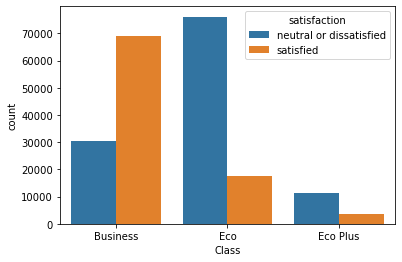

In [206]:
class_satisfaction = aps.groupby(['Class', 'satisfaction'])['Class'].agg(count = len).reset_index()
sns.barplot(data=class_satisfaction, x='Class', y='count', hue='satisfaction')

Widzimy, że dla klasy Biznes klienci są dużo bardziej usatysfakcjonowani niż dla dwóch pozostałych.

In [207]:
def encode(df, col):
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

In [208]:
encode(aps, 'Gender')
encode(aps, 'Customer Type')
encode(aps, 'Type of Travel')
encode(aps, 'Class')

In [209]:
aps.groupby(['Class', 'satisfaction'])['Class'].agg(count = len).reset_index()

,Class,satisfaction,count
0,0,neutral or dissatisfied,30370
1,0,satisfied,68960
2,1,neutral or dissatisfied,76088
3,1,satisfied,17402
4,2,neutral or dissatisfied,11300
5,2,satisfied,3688


Encoder zakodował Biznes na 0, Eco na 1 i Eco Plus na 2. To znaczy zachował porządek.

Możemy zatem przejść do tworzenia modelu.

## Random Forest Clasifier

In [210]:
def process(df):
    df.loc[df['Arrival Delay in Minutes'].isna(), 'Arrival Delay in Minutes'] = 0
    cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    for col in cat_cols:
        encode(df, col)

In [211]:
process(X_train)
process(X_val)
process(X_test)

In [224]:
rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

In [225]:
rfc.score(X_train, y_train)

0.9991434400985525

In [226]:
rfc.score(X_val, y_val)

0.9991145672928857

Mamy zaskakująco wysoki wynik. Popatrzmy jaki wpływ mają hiperparametry (bo tutaj raczej nie uda się poprawić wyniku)

In [260]:
max_depths = np.arange(5, 31, 5)
min_splits = np.logspace(start = -5, stop = -1, num=15)
scores_train = np.empty(shape=(len(max_depths), len(min_splits)))       # bias
scores_val = np.empty(shape=(len(max_depths), len(min_splits)))         # variance

In [245]:
from IPython.display import clear_output

In [261]:
for i, depth in enumerate(max_depths):
    for j, split in enumerate(min_splits):
        # Korzystam tylko z 5, aby przyspieszyć proces
        clear_output(wait=True)
        print(f"Evaluating model {i * len(min_splits) + j} of {len(min_splits) * len(max_depths)}...\n")
        rfc = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=split)
        rfc.fit(X_train, y_train)
        scores_train[i, j] = rfc.score(X_train, y_train)
        scores_val[i, j] = rfc.score(X_val, y_val)

Evaluating model 89 of 90...



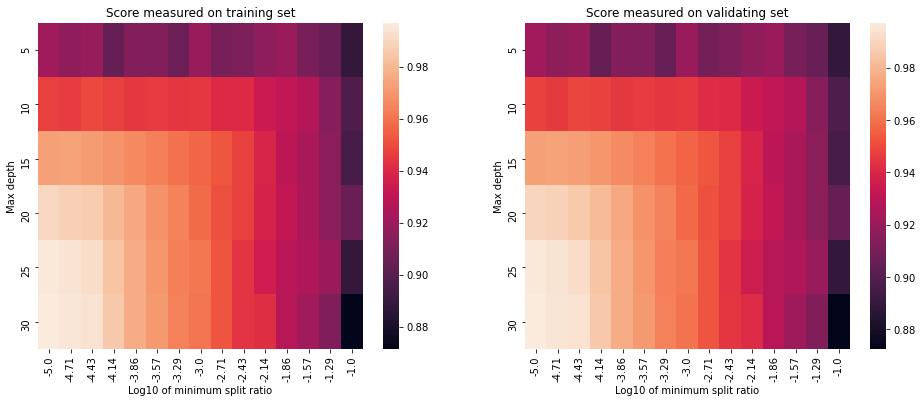

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].title.set_text("Score measured on training set")
axes[1].title.set_text("Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = scores_train, xticklabels=np.log10(min_splits).round(2), yticklabels=max_depths)
sns.heatmap(ax = axes[1], data = scores_val, xticklabels=np.log10(min_splits).round(2), yticklabels=max_depths)
axes[0].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
axes[1].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
plt.show()

In [263]:
scores_val.max()

0.9972282106559901

Raczej nie widać efektów przeuczenia, ale tak jak podejrzewałem nawet najlepszy wynik jest gorszy niż dla domyślnych hiperparametrów.

Możemy sprawdzić jakie znaczenie ma liczba estymatorów.

<AxesSubplot:>

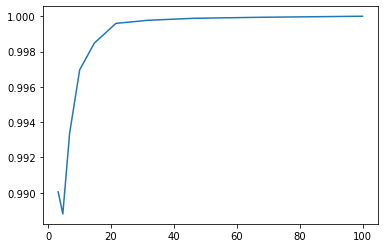

In [264]:
committee_size = np.logspace(0.5, 2, 10)
size_score = np.empty(committee_size.shape[0])
for i, cs in enumerate(committee_size):
    rfc = RandomForestClassifier(n_estimators=np.int32(cs))
    rfc.fit(X_train, y_train)
    size_score[i] = rfc.score(X_val, y_val)
sns.lineplot(x=committee_size, y=size_score)


Tutaj nie mamy takiego problemu jak dla XGBRegressor

In [265]:
rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

1.0

Dla wystarczająco dużej liczby esymatorów mamy idealny (?) model.

## XGBClasifier

In [268]:
xgbc = xgb.XGBClassifier(objective='binary:logistic')
xgbc.fit(X_train, y_train)

C:\Users\jasie\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:10:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [269]:
xgbc.score(X_val, y_val)

0.9740144748999076

Tym razem nie zaczynamy już z aż tak dobrym modelem. Może uda się coś poprawić.

In [281]:
max_depths = np.arange(20, 43, 2)
learning_rates = np.logspace(0.05, 0.1, 20)

scores_train = np.empty(shape=(len(max_depths), len(learning_rates)))       # bias
scores_val = np.empty(shape=(len(max_depths), len(learning_rates)))         # variance

In [283]:
for i, depth in enumerate(max_depths):
    for j, lr in enumerate(learning_rates):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(learning_rates) + j} of {len(learning_rates) * len(max_depths)}...\n")
        xgbc = xgb.XGBClassifier(max_depth=depth, learning_rate=lr, n_estimators=5)
        xgbc.fit(X_train, y_train)
        scores_train[i, j] = xgbc.score(X_train, y_train)
        scores_val[i, j] = xgbc.score(X_val, y_val)

Evaluating model 239 of 240...



C:\Users\jasie\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


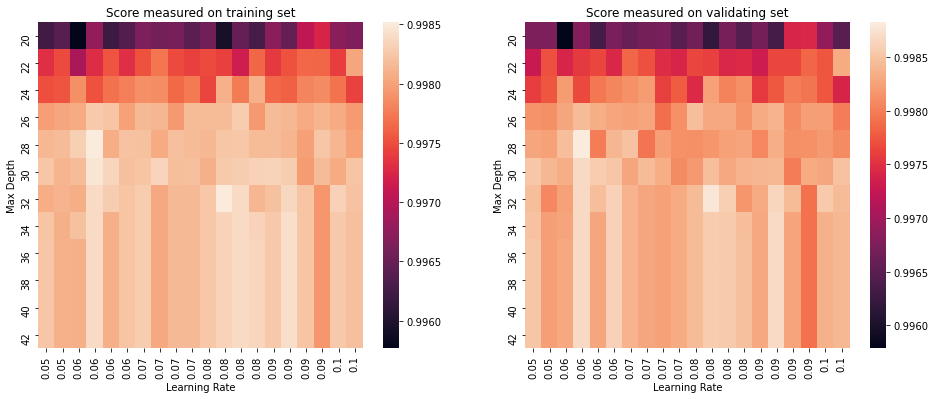

In [284]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].title.set_text("Score measured on training set")
axes[1].title.set_text("Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = scores_train, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
sns.heatmap(ax = axes[1], data = scores_val, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
axes[0].set(xlabel="Learning Rate", ylabel="Max Depth")
axes[1].set(xlabel="Learning Rate", ylabel="Max Depth")
plt.show()

Znów nie widać przeuczenia, a poprawił się wynik na zbiorze walidacyjnym.

In [286]:
idxmax = np.unravel_index(scores_val.argmax(), (12, 20))
argmax = max_depths[idxmax[0]], learning_rates[idxmax[1]]
argmax

(28, 1.142601360502879)

In [288]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


<AxesSubplot:>

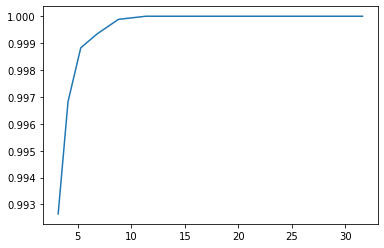

In [291]:
committee_size = np.logspace(0.5, 1.5, 10)
size_score = np.empty(committee_size.shape[0])
for i, cs in enumerate(committee_size):
    xgbc = xgb.XGBClassifier(max_depth=argmax[0], learning_rate=argmax[1], n_estimators=np.int32(cs), use_label_encoder=False, eval_metric='logloss')
    xgbc.fit(X_train, y_train)
    size_score[i] = xgbc.score(X_val, y_val)
sns.lineplot(x=committee_size, y=size_score)

Dla większej liczby estymatorów mamy lepszy wynik.

In [293]:
xgbc = xgb.XGBClassifier(max_depth=argmax[0], learning_rate=argmax[1], n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgbc.fit(X_train, y_train)
xgbc.score(X_test, y_test)

1.0

Odpowiednim dostrajaniem hiperparametrów tutaj także udało się osiągnąć idealny (?) model.